In [34]:
import pandas as pd
import networkx as nx
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import igraph
import numpy as np
import statistics

In [35]:
#Cream el link base on canviarem les diferents ids dels tornejos que extreim del fitxer csv
nom_arxiu = "TournamentSearch.xls"
link_base = "https://chess-results.com/tnr"
fitxer = pd.read_excel(nom_arxiu)

In [36]:
fitxer = fitxer[fitxer["Equipos"]==0]
id_tornejos=[i for i in fitxer["DB-Key"]]

In [37]:
#Funcio que utilitzarem més endevant per veure si dos tornejos han d'estar connectats
def intersequen_tornejos(torneig_1, torneig_2):
    return not(torneig_1["id_jugadors"].intersection(torneig_2["id_jugadors"])==set())

In [38]:
#Cream una llista amb tots els tornejos, on cada torneig tendrà la seva id i la dels jugadors participants
tornejos=[]
for id_torneig in id_tornejos:
    torneig_link = link_base + str(id_torneig) + ".aspx"
    page = requests.get(torneig_link)
    soup = bs(page.content, "html.parser")
    #Les classes de les diferents ids del jugadors son una combinacio de les llistes trs_class
    trs_class1=['CRg', 'CRng']
    trs_class2=['1', '2']
    trs_class3=['',' ESP', ' CAT', ' SE']
    ids=set()
    #Per ada torneig agafam les ids dels seus jugadors
    for a in trs_class1:
        for b in trs_class2:
            for c in trs_class3:
                participants = soup.find_all('tr', class_=a+b+c)
                ids0= {participants[i].find_all('a')[1].text for i in range(len(participants)) if(len(participants[i].find_all('a'))>1)}
                ids = ids|ids0
    if(len(ids)>0):
        torneig={
            "id_torneig": id_torneig,
            "id_jugadors": ids
        }
        #Finalment afegim el nou torneig a la llista total
        tornejos.append(torneig)


In [39]:
#Cream el graf, primer afegint els nodes i despres les arestes amb l'ajuda de la funció anterior
G=igraph.Graph(n=len(tornejos), vertex_attrs={'id_torneig': [torneig['id_torneig'] for torneig in tornejos]})
for i in range(len(tornejos)):
    for j in range(len(tornejos)):
        if(i>j):
            if(intersequen_tornejos(tornejos[i],tornejos[j])):
                G.add_edge(i,j)



In [40]:
#Calculam alguns valors del graf
nombre_vertexos = G.vcount()
nombre_arestes = G.ecount()
grau_mig = statistics.mean(G.degree())
cami_mig = G.average_path_length()
diametre = G.diameter()
print("Nombre vèrtexos: "+ str(nombre_vertexos))
print("Nombre arestes: " + str(nombre_arestes))
print("Grau mig: "+str(grau_mig))
print("Distància mitja dels camins: "+str(cami_mig))
print("Diàmetre: "+str(diametre))

Nombre vèrtexos: 596
Nombre arestes: 7654
Grau mig: 25.684563758389263
Distància mitja dels camins: 3.070088303659897
Diàmetre: 8


23
52
250


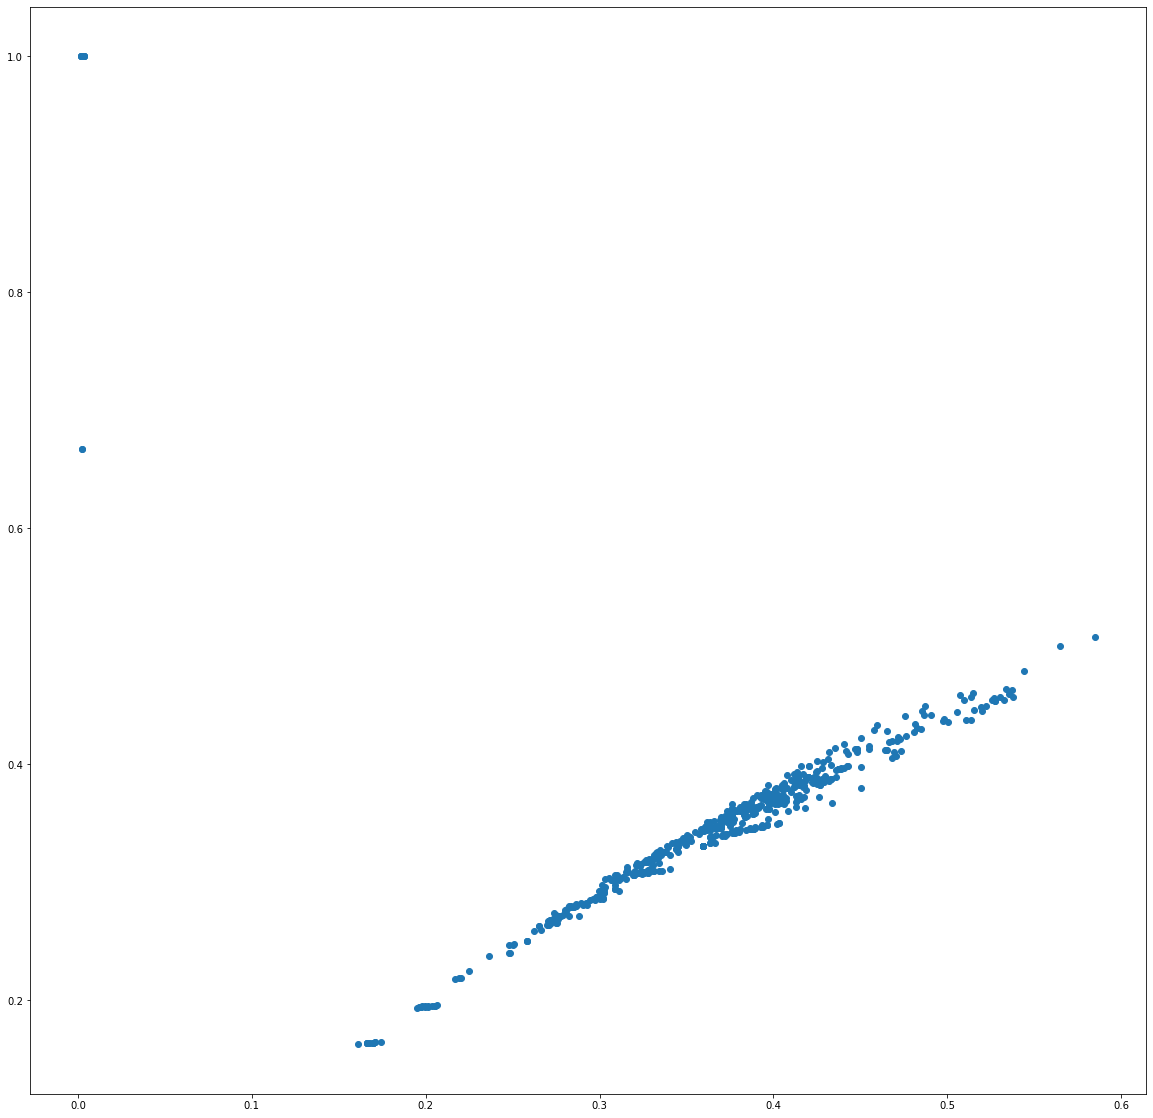

In [41]:
#calculam els tornejos amb l'índex major de les diferents métriques
betw = G.betweenness()
clos = G.closeness()
harm = G.harmonic_centrality()
clust = G.transitivity_undirected()
print(betw.index(max(betw)))
print(clos.index(max(clos)))
print(harm.index(max(harm)))
plt.scatter(harm, clos)

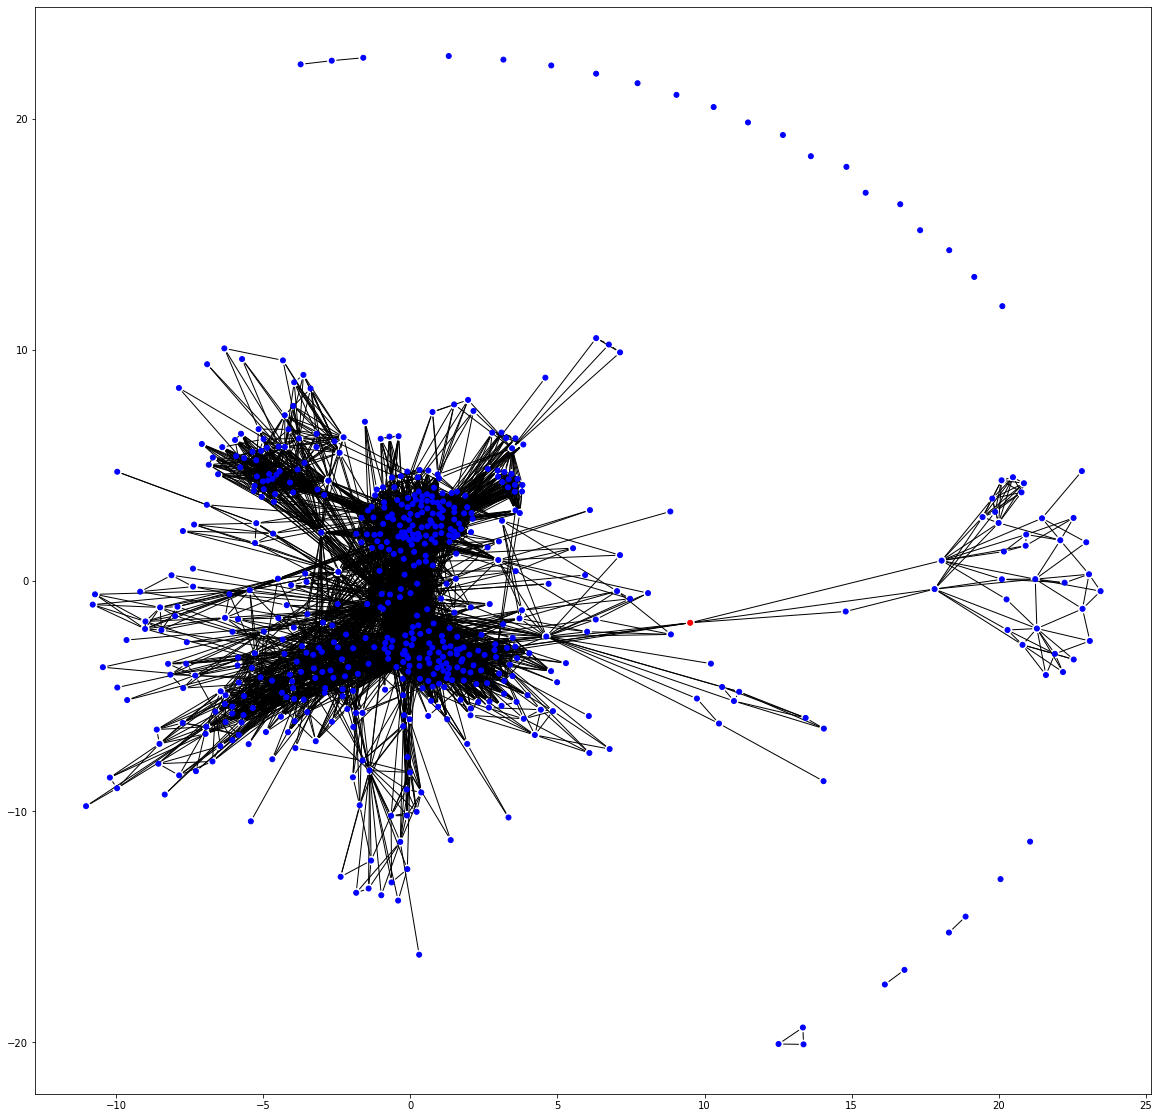

In [42]:
#Dibuixam el graf i marcam el node corresponent al torneig amb id 526072 en vermell
colors=[]
for torneig in tornejos:
    if(torneig["id_torneig"]==526072):
        colors.append("red")
    else:
        colors.append("blue")


plt.rcParams['figure.figsize']=[20,20]
fig, ax =plt.subplots()
layout = G.layout("lgl")#"kamada_kawai","auto","fruchterman_reingold","sugiyama"
igraph.plot(G, target=ax)#, layout=layout
dots = ax.get_children()[0]
dots.set_color(colors)

In [43]:
graus=list(G.degree())
print(graus.index(max(graus)))
graus[250]
tornejos[250]["id_torneig"]

250


528123

<BarContainer object of 99 artists>

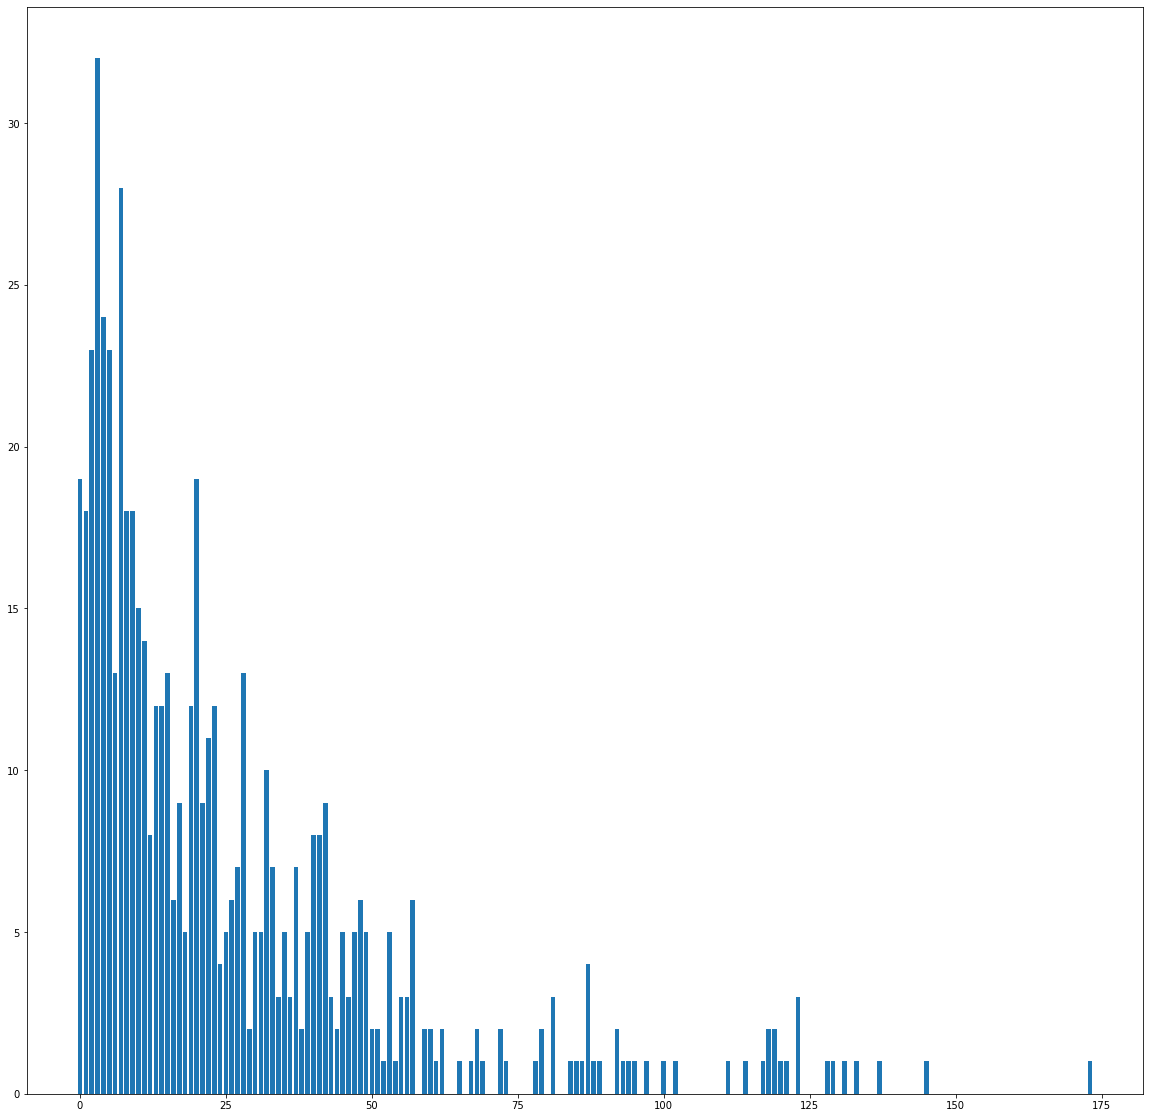

In [44]:
#Graficam la distribució dels graus
valors, quantitats = np.unique(graus, return_counts=True)
plt.bar(valors,quantitats)


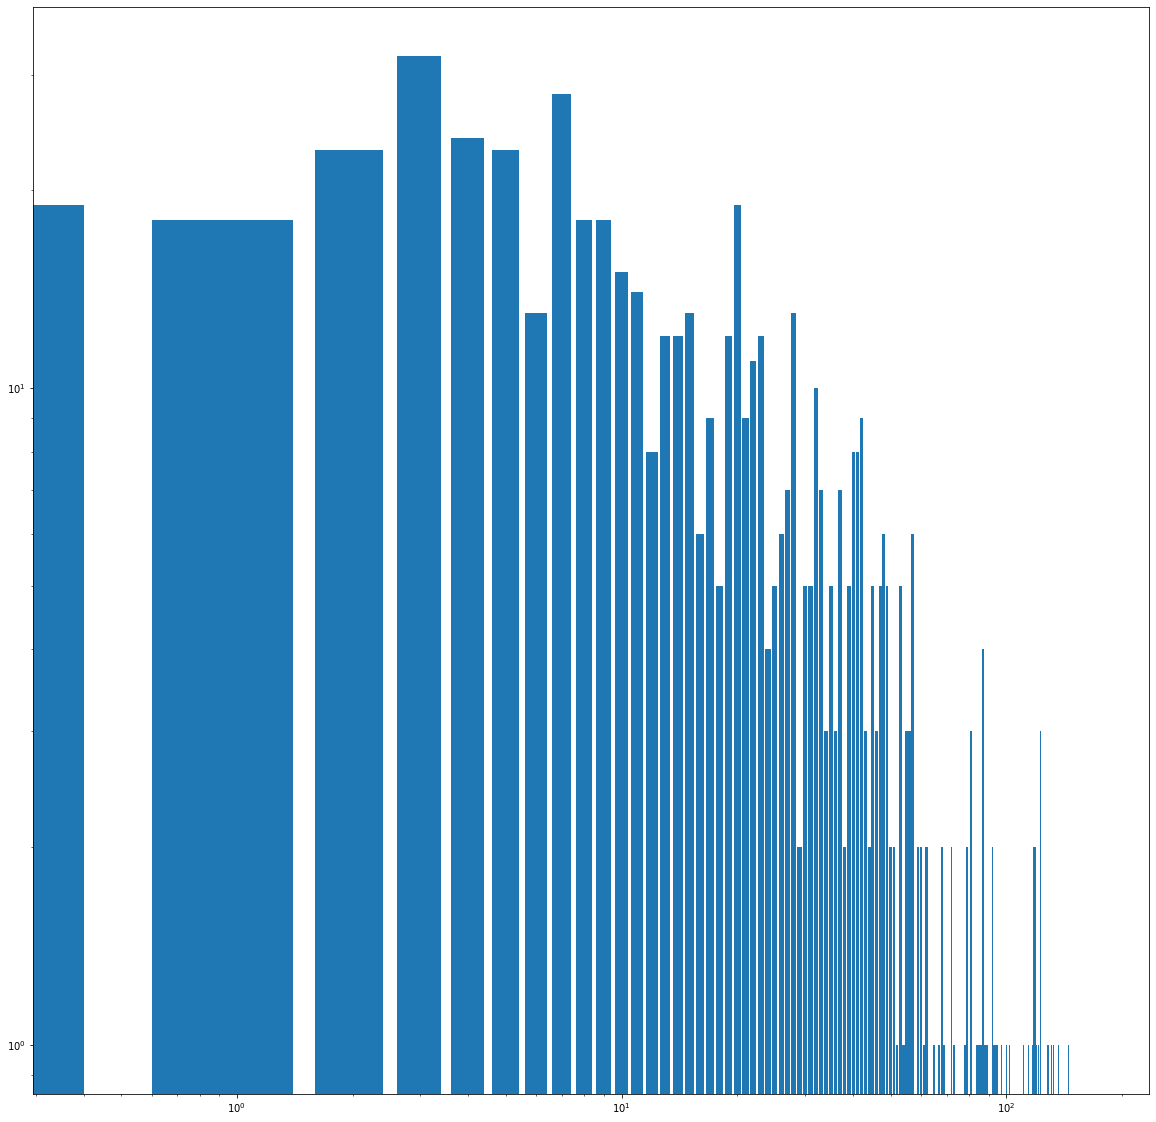

In [45]:
#Graficam la dsitribució dels graus a una escala log-log
plt.bar(valors,quantitats)
plt.xscale("log")
plt.yscale("log")